# Geospatial Data Analysis - Raster Data
Geospatial data such as satellite imagery or elevation model are represented as one or more matrices of values. For example an image is usually represented as three matrices (bands) of values in the Red, Blue or Green colors. Each pixel of the image is represented by three RGB values. Satellite imagery may have more than three bands depending on the type of sensor used in the acquisition. Digital elevetion models (DEMs) and land cover models are represented as single band raster data. In this section we'll see how raster data can be read, processed and written in a file.

The upper-left corner of an image represents the origin (0, 0). The x axis goes from the origin to the left while the y axis goes from the origin to the bottom of the image. We use the [GDAL Python binding](https://gdal.org/tutorials/raster_api_tut.html)  to read and write GeoTIFF files that contain the raster data and metadata. We use the [PIL](https://pillow.readthedocs.io/en/stable/index.html) Python package to render the images and Matplotlib to visualize them in the notebook.

In [1]:
import os
import numpy as np
from osgeo import gdal
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

We want to stack three raster images, acquired by a Landsat satellite, into a GeoTIFF file so that they can be used as RGB bands. Let's have a look at one of them

TIFF (8849, 8023) L


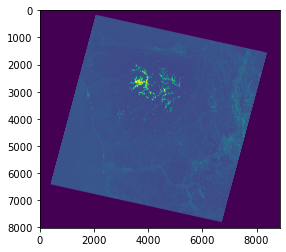

In [2]:
path = 'data/raster/Landsat/Washington/'
band1_fn = path + 'p047r027_7t20000730_z10_nn10.tif'
band2_fn = path + 'p047r027_7t20000730_z10_nn20.tif'
band3_fn = path + 'p047r027_7t20000730_z10_nn30.tif'
im_band1 = Image.open(band1_fn)
print(im_band1.format, im_band1.size, im_band1.mode)
plt.imshow(im_band1)

The image files are provided in GeoTIFF format with one single band so we extract information from their metadata such as the image size for each dimension, the spatial reference system and the coordinates of the origin.

In [20]:
in_ds = gdal.Open(band1_fn)
in_band = in_ds.GetRasterBand(1)
in_band.XSize, in_band.YSize, in_band.DataType, in_ds.GetProjection()

(8849,
 8023,
 1,
 'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]')

In [34]:
x_origin, x_pixel_resolution, row_rotation, y_origin, column_rotation, y_pixel_resolution = in_ds.GetGeoTransform()
print('x_origin: {}, y_origin: {}, pixel resolution: {}'.format(x_origin, y_origin, x_pixel_resolution))

x_origin: 343724.25, y_origin: 5369585.25, pixel resolution: 28.5


We create a new GeoTIFF file with three bands of the same size and spatial reference system as the images

In [22]:
gtiff_driver = gdal.GetDriverByName('GTiff')
out_ds = gtiff_driver.Create(path + 'nat_color.tif', in_band.XSize, in_band.YSize, 3, in_band.DataType)
out_ds.SetProjection(in_ds.GetProjection())
out_ds.SetGeoTransform(in_ds.GetGeoTransform())

0

We copy the raster data of the 1st image into the 3rd band of the created GeoTIFF file

In [23]:
in_data = in_band.ReadAsArray()
out_band = out_ds.GetRasterBand(3)
out_band.WriteArray(in_data)

0

We open the 2nd image and we put the raster data into the 2nd band

In [24]:
in_ds = gdal.Open(band2_fn)
out_band = out_ds.GetRasterBand(2)
out_band.WriteArray(in_ds.ReadAsArray())

0

Finally we put the 3rd image into the 1st band

In [25]:
in_ds = gdal.Open(band3_fn)
out_band = out_ds.GetRasterBand(1)
out_band.WriteArray(in_ds.ReadAsArray())

0

we write the data on disk. If the file is a new one we have to close the data source as well.

In [28]:
out_ds.FlushCache() 

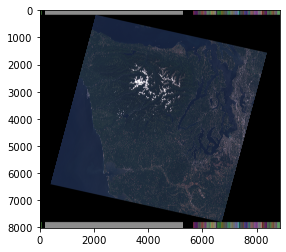

In [29]:
im_natcol = Image.open(path + 'nat_color.tif')
plt.imshow(im_natcol)

we compute some statistical values for each band: mean, min, max and standard deviation. We create also some overview layers for each band to be visualized at different zoom levels.

In [30]:
for i in range(1, 4):
    out_ds.GetRasterBand(i).ComputeStatistics(False)
    out_ds.BuildOverviews('average', [2, 4, 8, 16, 32])
del out_ds

### Raster data subsetting
Satellite imagery cover large areas of the Earth surface. If we are interested only in a subset of such areas it is worthwhile to copy that subset in a new file in order to reduce its processing time.  

Let's say we are interested only in the area covered by the snow in the Landsat band1 imagery we have used in the previous section. In order to select an area inside the original image we have to apply an affine transformation that copies the pixels in the original image to the new one keeping the same metrics (i.e. distance). The affine transformation we are going to define is more precisely a translation, that is we will not apply any rotation.

In [3]:
band1_ds = gdal.Open(band1_fn)
x_offset, x_resolution, x_rotation, y_offset, y_rotation, y_resolution = band1_ds.GetGeoTransform()
print('x_offset: {} m, y_offset: {} m, x_resolution: {} m, y_resolution: {} m'.format(x_offset, y_offset, x_resolution, abs(y_resolution)))

x_offset: 343724.25 m, y_offset: 5369585.25 m, x_resolution: 28.5 m, y_resolution: 28.5 m


In [4]:
band1 = band1_ds.GetRasterBand(1)
print(band1.XSize, band1.YSize)
x_length = band1.XSize * x_resolution
y_length = band1.YSize * y_resolution
print('x length: {:.1f} km, y length: {:.1f} km'.format(x_length / 1000, abs(y_length) / 1000))

8849 8023
x length: 252.2 km, y length: 228.7 km


We want to move the offset of the subset image 90 km to the east and 60 km to the south

In [5]:
x_delta = 90000
y_delta = -60000
x_subset_offset = x_offset + x_delta # meter
y_subset_offset = y_offset + y_delta # meters
subset_transform = [x_subset_offset, x_resolution, x_rotation, y_subset_offset, y_rotation, y_resolution]
subset_transform

[433724.25, 28.5, 0.0, 5309585.25, 0.0, -28.5]

Then we want the length of the subset image to be 20 km to the east and 30 km to the south

In [6]:
x_subset_length = 30000 # meters
y_subset_length = 30000 # meters

We need to compute the number of pixels that corresponds to the size of the image for each direction

In [7]:
x_window_length = round(x_subset_length / x_resolution)
y_window_length = round(y_subset_length / abs(y_resolution))
x_window_length, y_window_length

(1053, 1053)

We also need to compute the pixel indexes that corresponds to the new offset 

In [8]:
x_window_start = round(x_delta / x_resolution)
y_window_start = round(abs(y_delta / y_resolution))
x_window_start, y_window_start

(3158, 2105)

We create a new GeoTiff file for the image subset, with one band and the size we want. We also set the offset of the subset image in the file metadata.

In [9]:
gtiff_driver = gdal.GetDriverByName('GTiff')
subset_ds = gtiff_driver.Create(path + 'subset.tif', xsize=x_window_length, ysize=y_window_length, bands=1, eType=band1.DataType)
subset_ds.SetProjection(band1_ds.GetProjection())
subset_ds.SetGeoTransform(subset_transform)
subset_band = subset_ds.GetRasterBand(1)

In [11]:
data = band1.ReadAsArray()
rows_start = y_window_start
rows_end = y_window_start + y_window_length
cols_start = x_window_start
cols_end = x_window_start + x_window_length
subset_data = data[rows_start:rows_end, cols_start:cols_end]
print(np.shape(subset_data))
subset_band.WriteArray(subset_data)
subset_ds.FlushCache() 
subset_ds = None
band1_ds = None

(1053, 1053)


Now we can plot the subset image

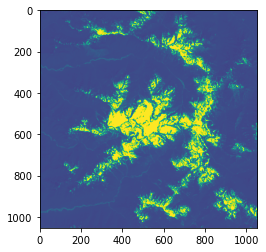

In [12]:
subset_img = Image.open(path + 'subset.tif')
plt.imshow(subset_img)